In [1]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(car)
library(GGally)
library(forcats)
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(leaps)
#library(bestglm)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combin

## Data description

This data was extracted from the census bureau database in 1994 found at http://www.census.gov/ftp/pub/DES/www/welcome.html and it is separated into train and test by a proportion of $\frac{2}{3}$

The variable's descriptions are:

+ age: continuous.

+ workclass:Factor with levels Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

+ fnlwgt: continuous. (final weight)
 The weights on the CPS files are controlled to independent estimates of the
 civilian noninstitutional population of the US.  These are prepared monthly
 for us by Population Division here at the Census Bureau.  We use 3 sets of
 controls.
  These are:
  
          1.  A single cell estimate of the population 16+ for each state.
          2.  Controls for Hispanic Origin by age and sex.
          3.  Controls by Race, age and sex.
 We use all three sets of controls in our weighting program and "rake" through
 them 6 times so that by the end we come back to all the controls we used.
 The term estimate refers to population totals derived from CPS by creating
 "weighted tallies" of any specified socio-economic characteristics of the
 population.

 People with similar demographic characteristics should have
 similar weights.  There is one important caveat to remember
 about this statement.  That is that since the CPS sample is
 actually a collection of 51 state samples, each with its own
 probability of selection, the statement only applies within
 state.

+ education:Factor with levels Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

+ education-num: Number of years spent in education. Continuous.

+ marital-status:Factor with levels Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

+ occupation:Factor with levels Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

+ relationship:Factor with levels Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

+ race:Factor with levels White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

+ sex:Factor with levels Female, Male.

+ capital-gain: continuous.

+ capital-loss: continuous.

+ hours-per-week: continuous.

+ native-country:Factor with levels United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

+ income: Wheter or not a person's income is less or more than 50000 $ a year

## Question
The question we are interested in is:
Can gender, education level, and occupation predict whether annual income of an individual exceeds $50K/yr?

We focus on prediction of wether an an individual exceeds $50K/yr but we also want to infere the statistical significance of the variables involved in the corresponding model, and also see if using other variables create a better model


## Exploratory Data Analysis and Visualization

We will begin by downloading the data, taking into account that the missing values are coded as ?

In [2]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/static/public/2/adult.zip",temp)
adult_train <- read.table(unz(temp, "adult.data"),sep=",",na.strings=' ?',stringsAsFactors=TRUE)
adult_test <- read.table(unz(temp, "adult.test"),sep=",",na.strings=' ?',stringsAsFactors=TRUE,skip=1)
unlink(temp)

We will change the column's names so they are representative

In [3]:
colnames(adult_train)=c("age","workclass","fnlwgt","education","education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","income")
colnames(adult_test)=c("age","workclass","fnlwgt","education","education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","income")


Lets see the basic information of the dataframe

In [4]:
summary(adult_train)
str(adult_train)

      age                    workclass         fnlwgt       
 Min.   :17.00    Private         :22696   Min.   :  12285  
 1st Qu.:28.00    Self-emp-not-inc: 2541   1st Qu.: 117827  
 Median :37.00    Local-gov       : 2093   Median : 178356  
 Mean   :38.58    State-gov       : 1298   Mean   : 189778  
 3rd Qu.:48.00    Self-emp-inc    : 1116   3rd Qu.: 237051  
 Max.   :90.00   (Other)          :  981   Max.   :1484705  
                 NA's             : 1836                    
         education     education_num                  marital_status 
  HS-grad     :10501   Min.   : 1.00    Divorced             : 4443  
  Some-college: 7291   1st Qu.: 9.00    Married-AF-spouse    :   23  
  Bachelors   : 5355   Median :10.00    Married-civ-spouse   :14976  
  Masters     : 1723   Mean   :10.08    Married-spouse-absent:  418  
  Assoc-voc   : 1382   3rd Qu.:12.00    Never-married        :10683  
  11th        : 1175   Max.   :16.00    Separated            : 1025  
 (Other)      : 5134  

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : Factor w/ 8 levels " Federal-gov",..: 7 6 4 4 4 4 4 6 4 4 ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : Factor w/ 16 levels " 10th"," 11th",..: 10 10 12 2 10 13 7 12 13 10 ...
 $ education_num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital_status: Factor w/ 7 levels " Divorced"," Married-AF-spouse",..: 5 3 1 3 3 3 4 3 5 3 ...
 $ occupation    : Factor w/ 14 levels " Adm-clerical",..: 1 4 6 6 10 4 8 4 10 4 ...
 $ relationship  : Factor w/ 6 levels " Husband"," Not-in-family",..: 2 1 2 1 6 6 2 1 2 1 ...
 $ race          : Factor w/ 5 levels " Amer-Indian-Eskimo",..: 5 5 5 3 3 5 3 5 5 5 ...
 $ sex           : Factor w/ 2 levels " Female"," Male": 2 2 2 2 1 1 1 2 1 2 ...
 $ capital_gain  : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital_loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours_per_week: int  4

We see many things from this information, such that there are many more instances with <50K than with the alternative. We also see tha the `native_country` has many levels, and it also has missing variables, so we will drop this variable for our study. We also see that the 75 % of the values of `capital_gain` and `capital_loss` are 0, so we will drop those variables also. 

Now we will remove those variables and the missing values

In [5]:
adult_train=adult_train %>% select(!c(capital_gain,capital_loss,native_country))
adult_test=adult_test%>% select(!c(capital_gain,capital_loss,native_country))
adult_train=adult_train[complete.cases(adult_train),]
adult_test=adult_test[complete.cases(adult_test),]

head(adult_train)
n=nrow(adult_train)
n
nrow(adult_test)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,income
,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,<=50K


[1] 30718

[1] 15315

We have 30718 instances in the train split and 15315 in the test split

In [6]:
str(adult_train)

'data.frame':	30718 obs. of  12 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : Factor w/ 8 levels " Federal-gov",..: 7 6 4 4 4 4 4 6 4 4 ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : Factor w/ 16 levels " 10th"," 11th",..: 10 10 12 2 10 13 7 12 13 10 ...
 $ education_num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital_status: Factor w/ 7 levels " Divorced"," Married-AF-spouse",..: 5 3 1 3 3 3 4 3 5 3 ...
 $ occupation    : Factor w/ 14 levels " Adm-clerical",..: 1 4 6 6 10 4 8 4 10 4 ...
 $ relationship  : Factor w/ 6 levels " Husband"," Not-in-family",..: 2 1 2 1 6 6 2 1 2 1 ...
 $ race          : Factor w/ 5 levels " Amer-Indian-Eskimo",..: 5 5 5 3 3 5 3 5 5 5 ...
 $ sex           : Factor w/ 2 levels " Female"," Male": 2 2 2 2 1 1 1 2 1 2 ...
 $ hours_per_week: int  40 13 40 40 40 40 16 45 50 40 ...
 $ income        : Factor w/ 2 levels " <=50K"," >50K": 1 1 1 1 1 1 1 2 2

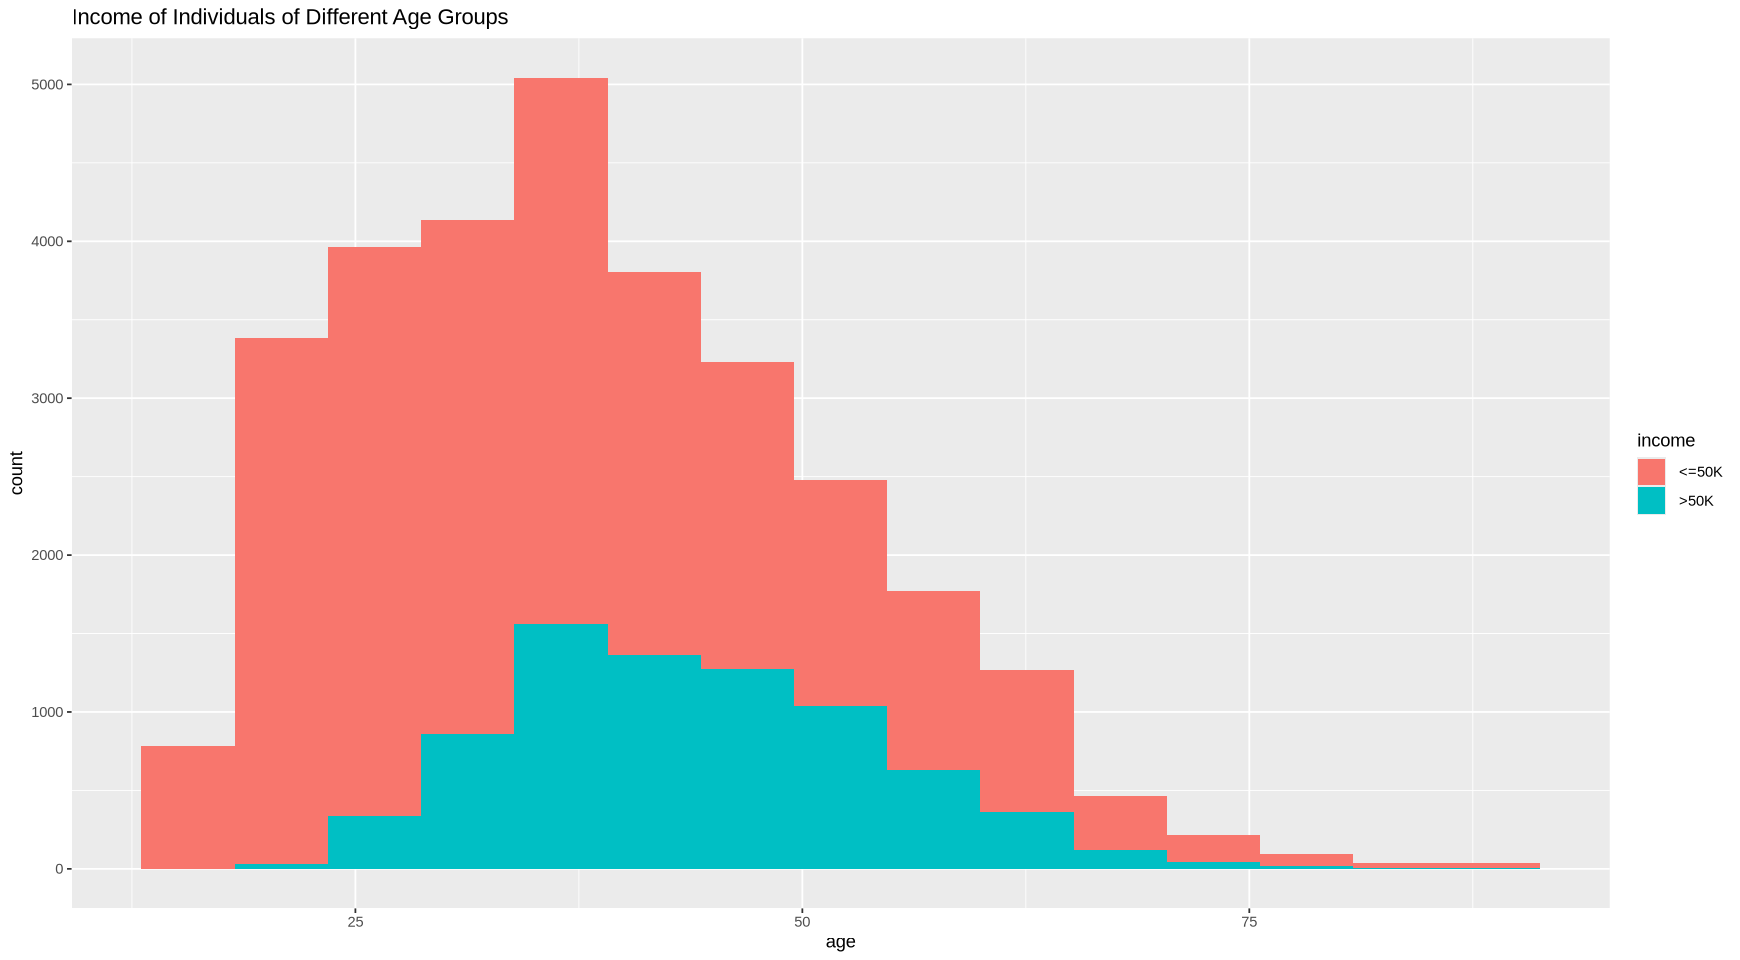

In [7]:
options(repr.plot.width = 14.5, repr.plot.height = 8) 
ggplot(adult_train,aes(age,fill=income))+
geom_histogram(bins=15)+ 
ggtitle("Income of Individuals of Different Age Groups")

We see that the amount of people with an income greater than $50k is very low  for people of less than 20 years and more of 65 years

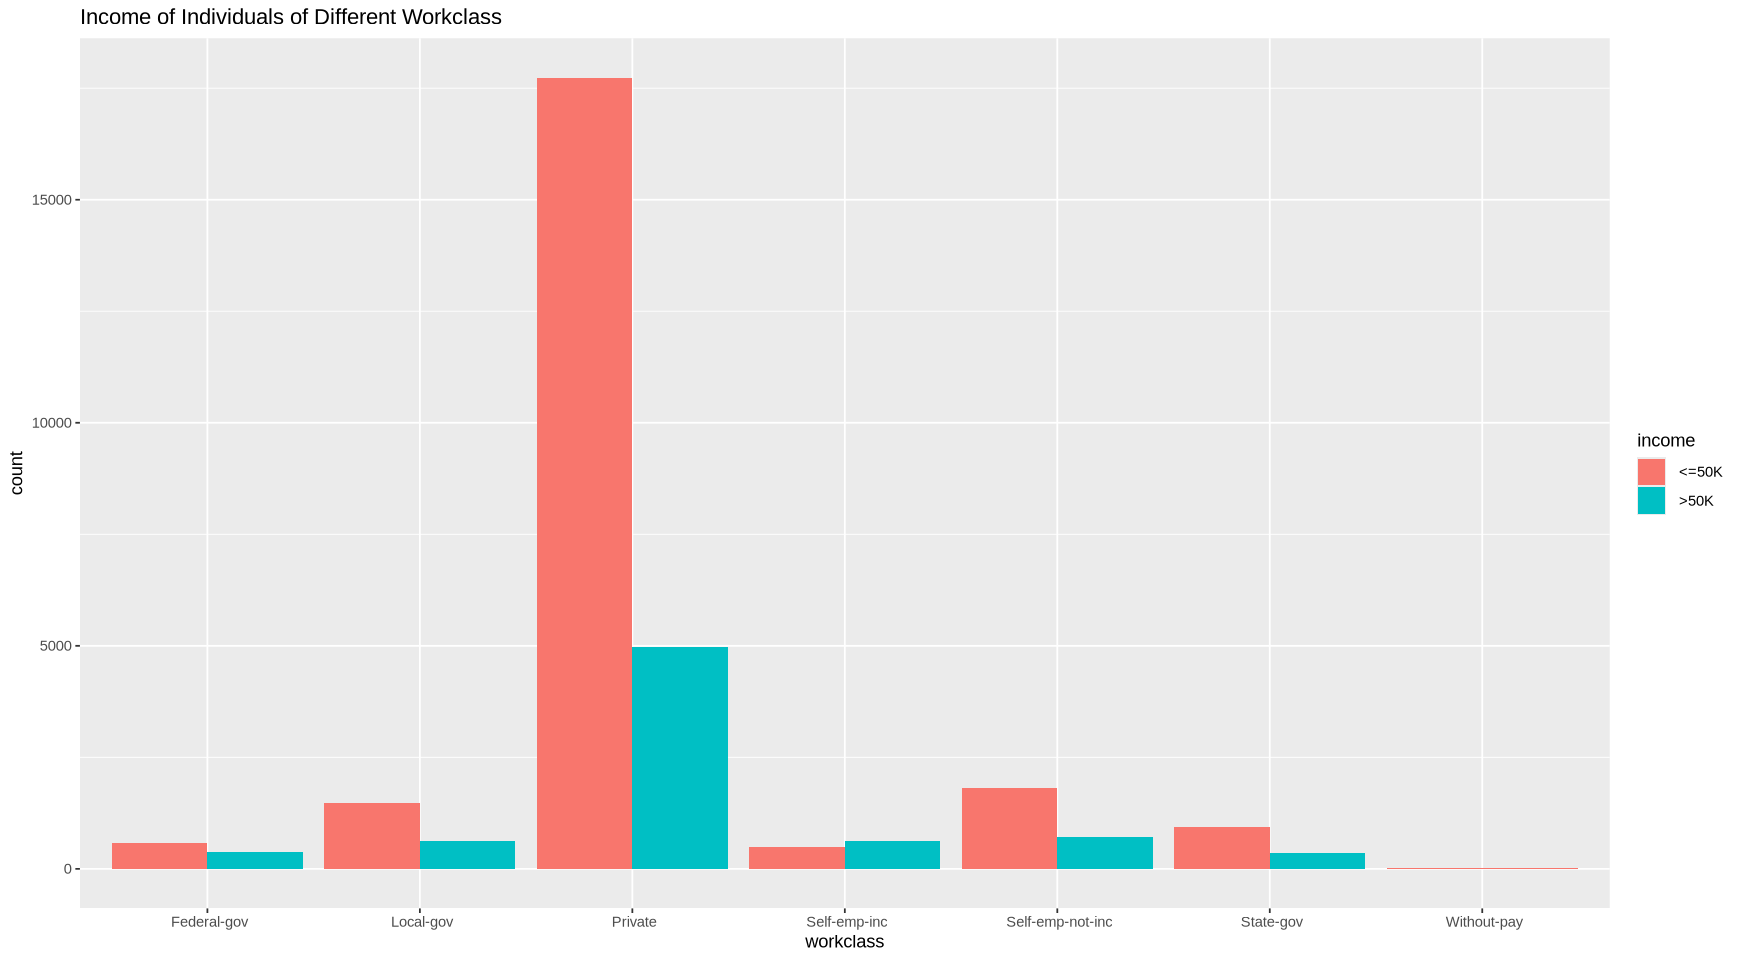

In [8]:
ggplot(adult_train,aes(workclass,fill=income))+
geom_bar(position='dodge')+ 
ggtitle("Income of Individuals of Different Workclass")

We clearly see that the majority of people work in `Private` and there is a big difference in income in that category, where nearly 0.25% earns more than \$50K. We also see that `Self-emply-inc` is the only factor with more people earning more than $50K a year than those who not

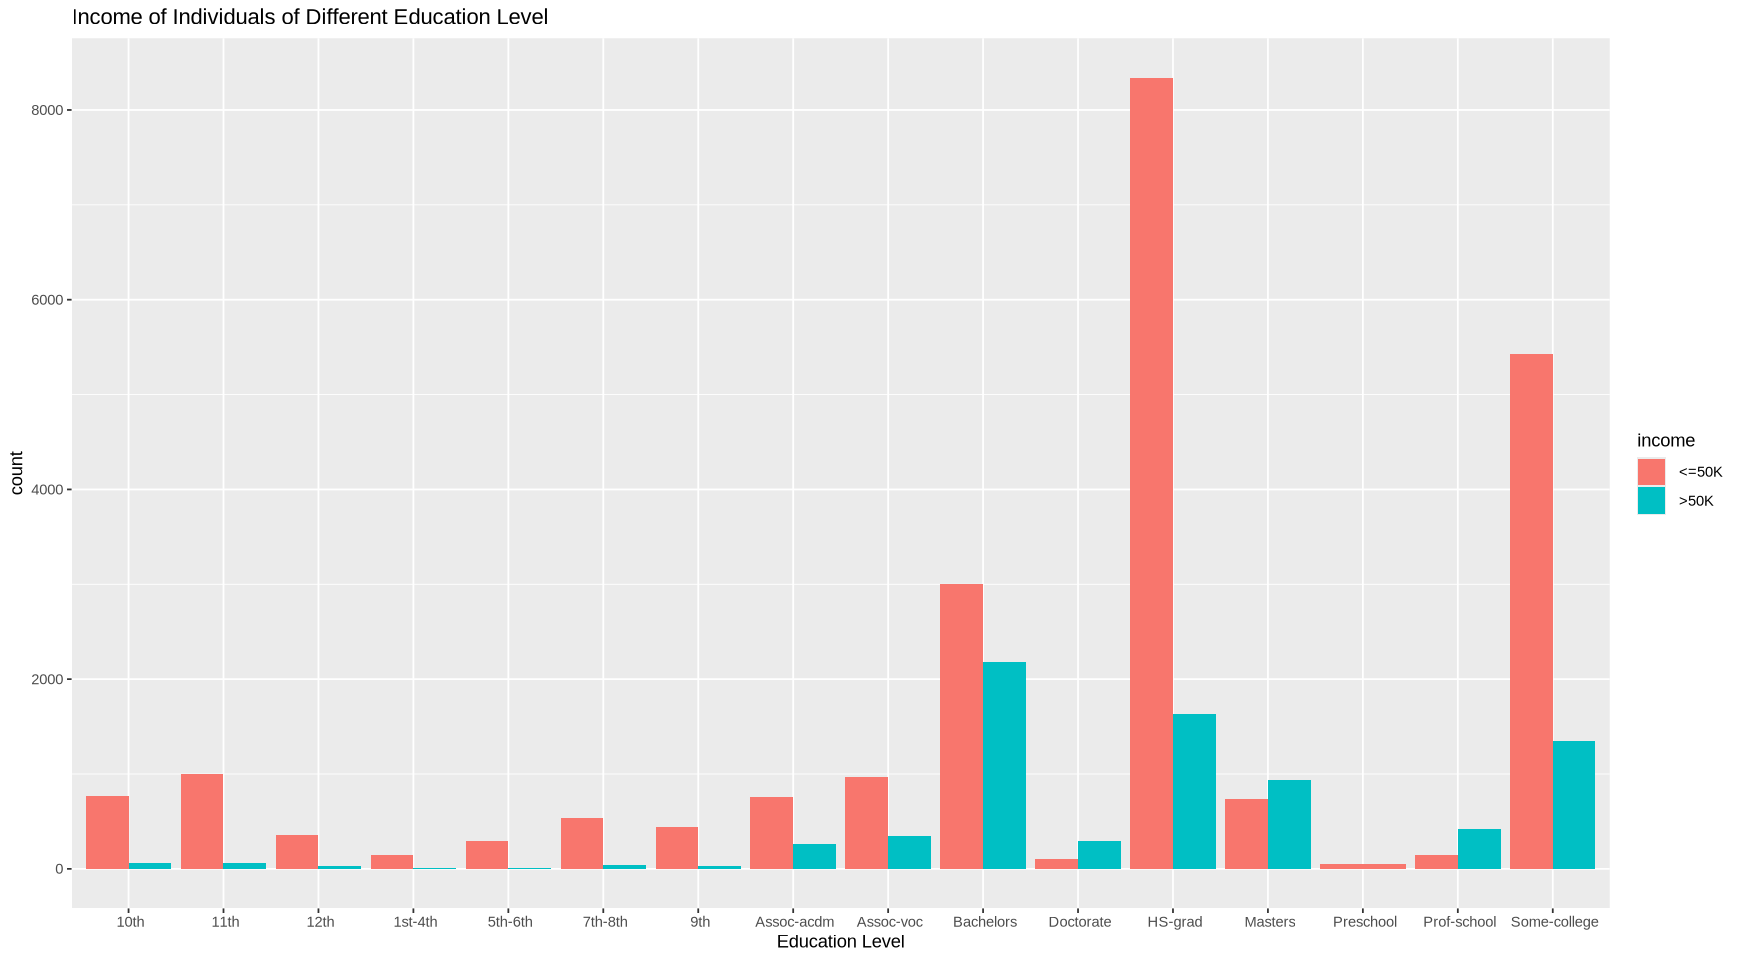

In [9]:
ggplot(adult_train,aes(education,fill=income))+
geom_bar(position='dodge')+ 
ggtitle("Income of Individuals of Different Education Level")+
xlab("Education Level")

For the people who have a lower or equal education level than 12th Standard, there are only a few who earn more than 50K dollars per year.
For the people belonging to `Bachelors`, `Masters`, `Doctorate`, `Prof-school` category in the education level, there are more people who are earning more than 50K dollars per year than the number of people earning less than that.

Due to the similarity of the education levels that are less than 12th in our study, and to reduce the number of levels, we will join them.

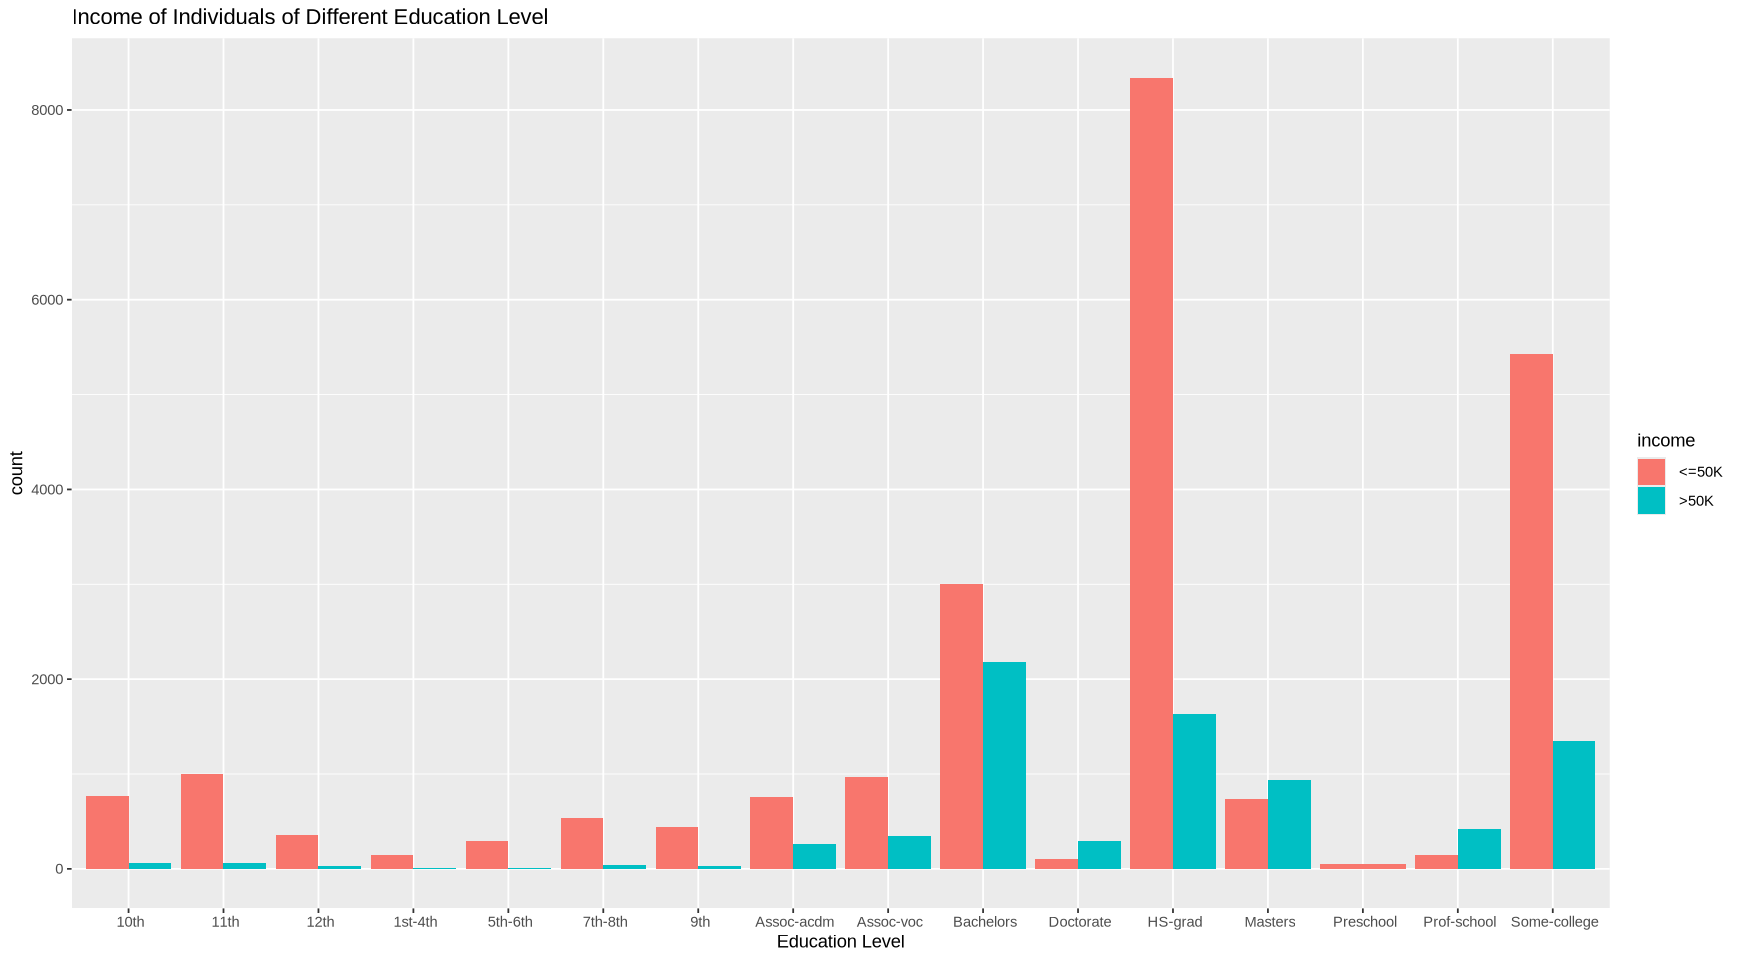

In [10]:
ggplot(adult_train,aes(education,fill=income))+
geom_bar(position='dodge')+ 
ggtitle("Income of Individuals of Different Education Level")+
xlab("Education Level")

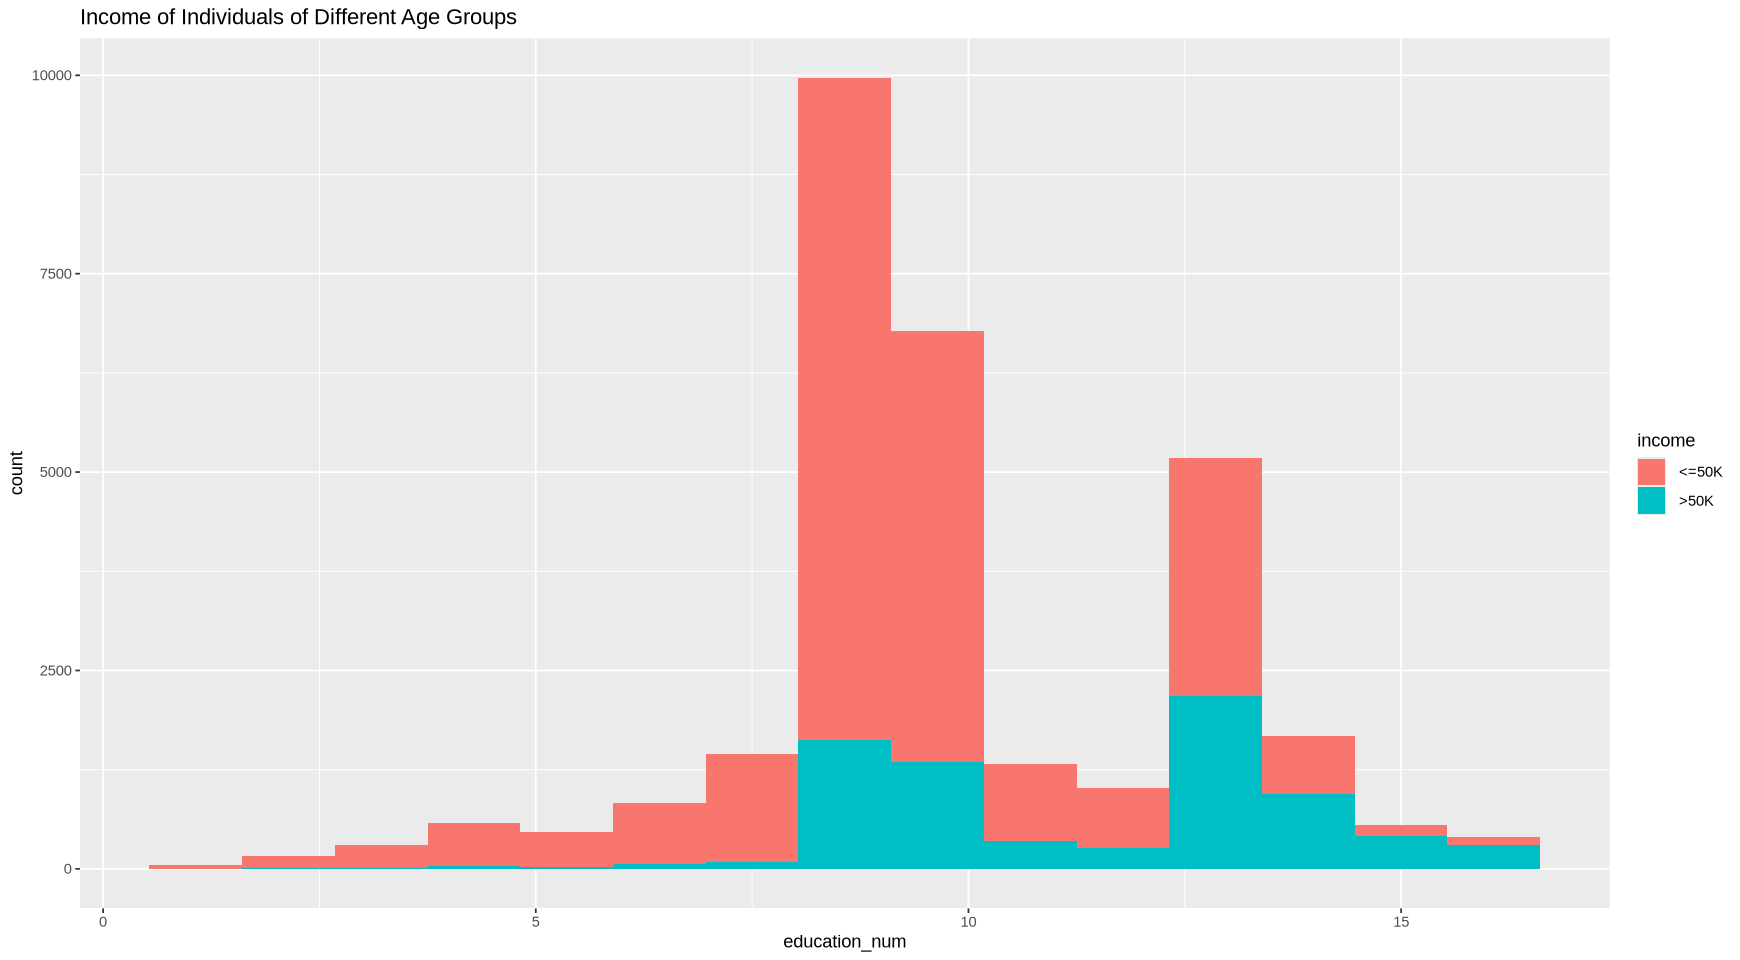

In [11]:
ggplot(adult_train,aes(education_num,fill=income))+
geom_histogram(bins=15)+ 
ggtitle("Income of Individuals of Different Age Groups")

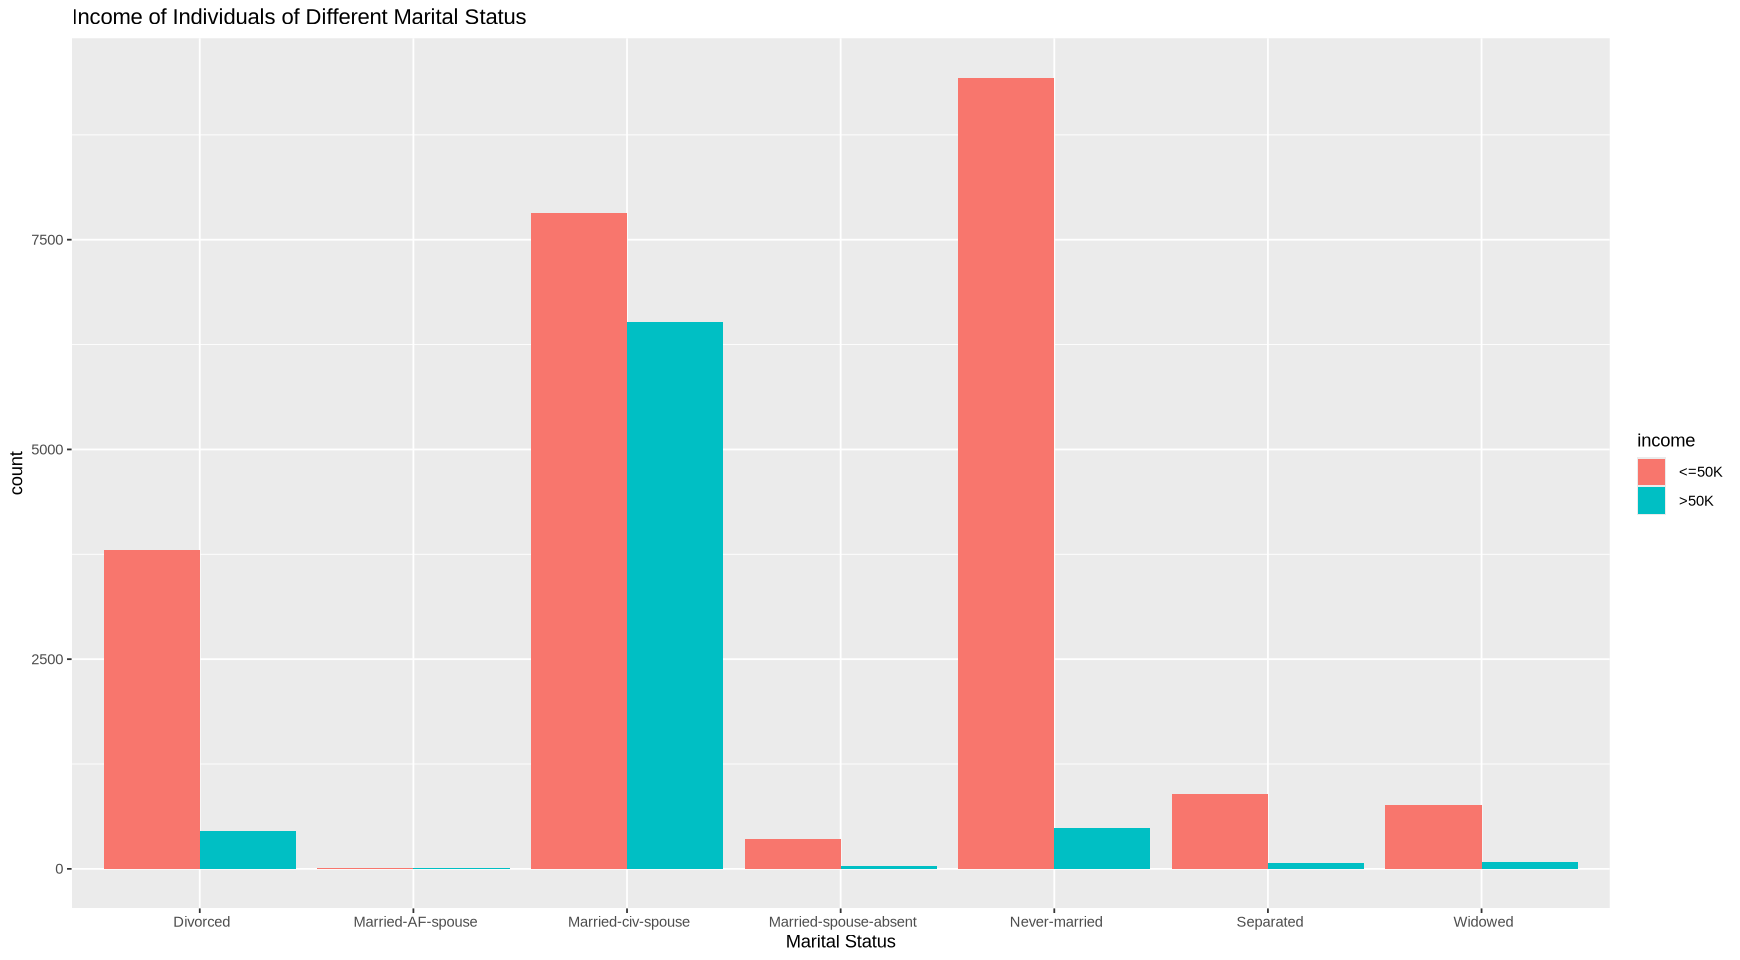

In [12]:
ggplot(adult_train,aes(marital_status,fill=income))+
geom_bar(position='dodge')+ 
ggtitle("Income of Individuals of Different Marital Status")+
xlab("Marital Status")

In [13]:
levels(adult_train$income)

[1] " <=50K" " >50K"

We see that `Married-civ-spouse` is the only category which has a comparable number of people belonging to both categories.
For the other categories, there are less than 25% of the adults earning more than 50K dollars an year.

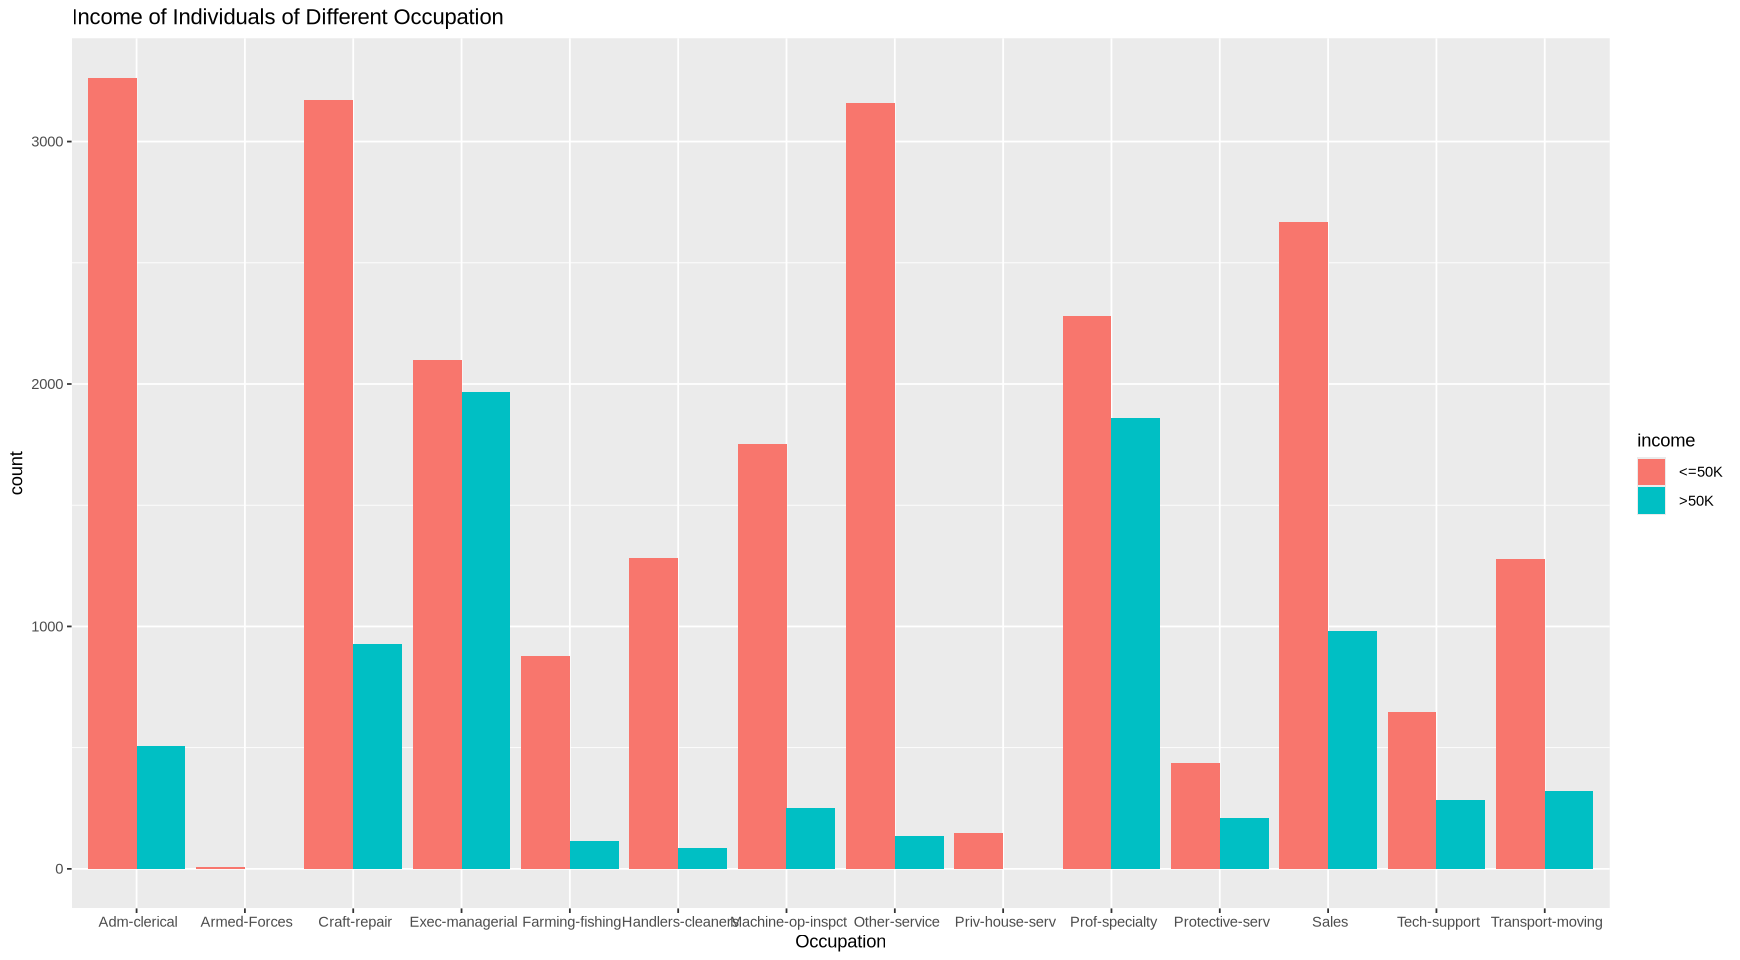

In [14]:
ggplot(adult_train,aes(occupation,fill=income))+
geom_bar(position='dodge')+ 
ggtitle("Income of Individuals of Different Occupation")+
xlab("Occupation")

We see that people in `Exec-managerial` roles are equally likely to earn more than 50K dollars per year.
There is close to a 33% probablity for a person in `Prof-specialty` to earn more than 50K dollars per year.
Only a few people working in `Farming-fishing`, `Machine-op-inspect`, `Other-service`, `Adm-clerical`, `Transport-moving` earn more than 50K dollars per year.
Around 25% of the people working in `Sales` earn more than 50K dollars an year.

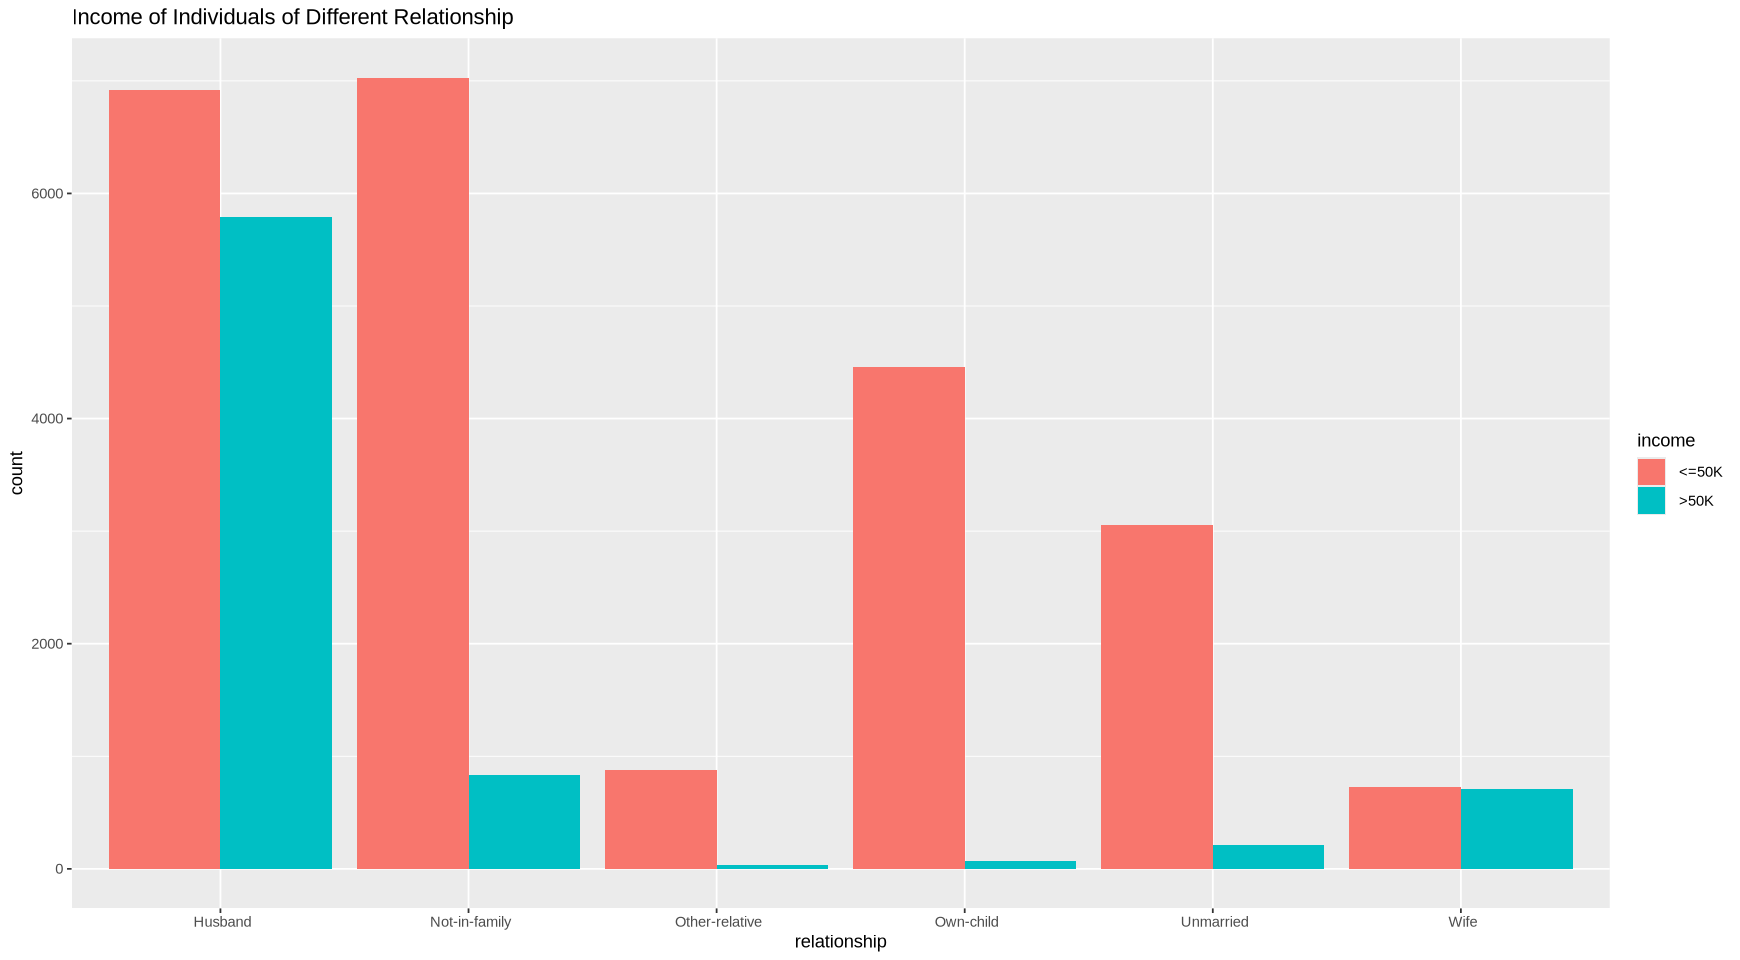

In [15]:
ggplot(adult_train,aes(relationship,fill=income))+
geom_bar(position='dodge')+ 
ggtitle("Income of Individuals of Different Relationship")

We see that there is a more or less an equal quantity of `Wives` that earn more than 50K dollars per year than those who does not.
For `Husbands`, although significant, there is less possibility of them to earn more than 50K dollars an year.
There are just a few of `Unmarried` people earning more than 50K dollars an year.

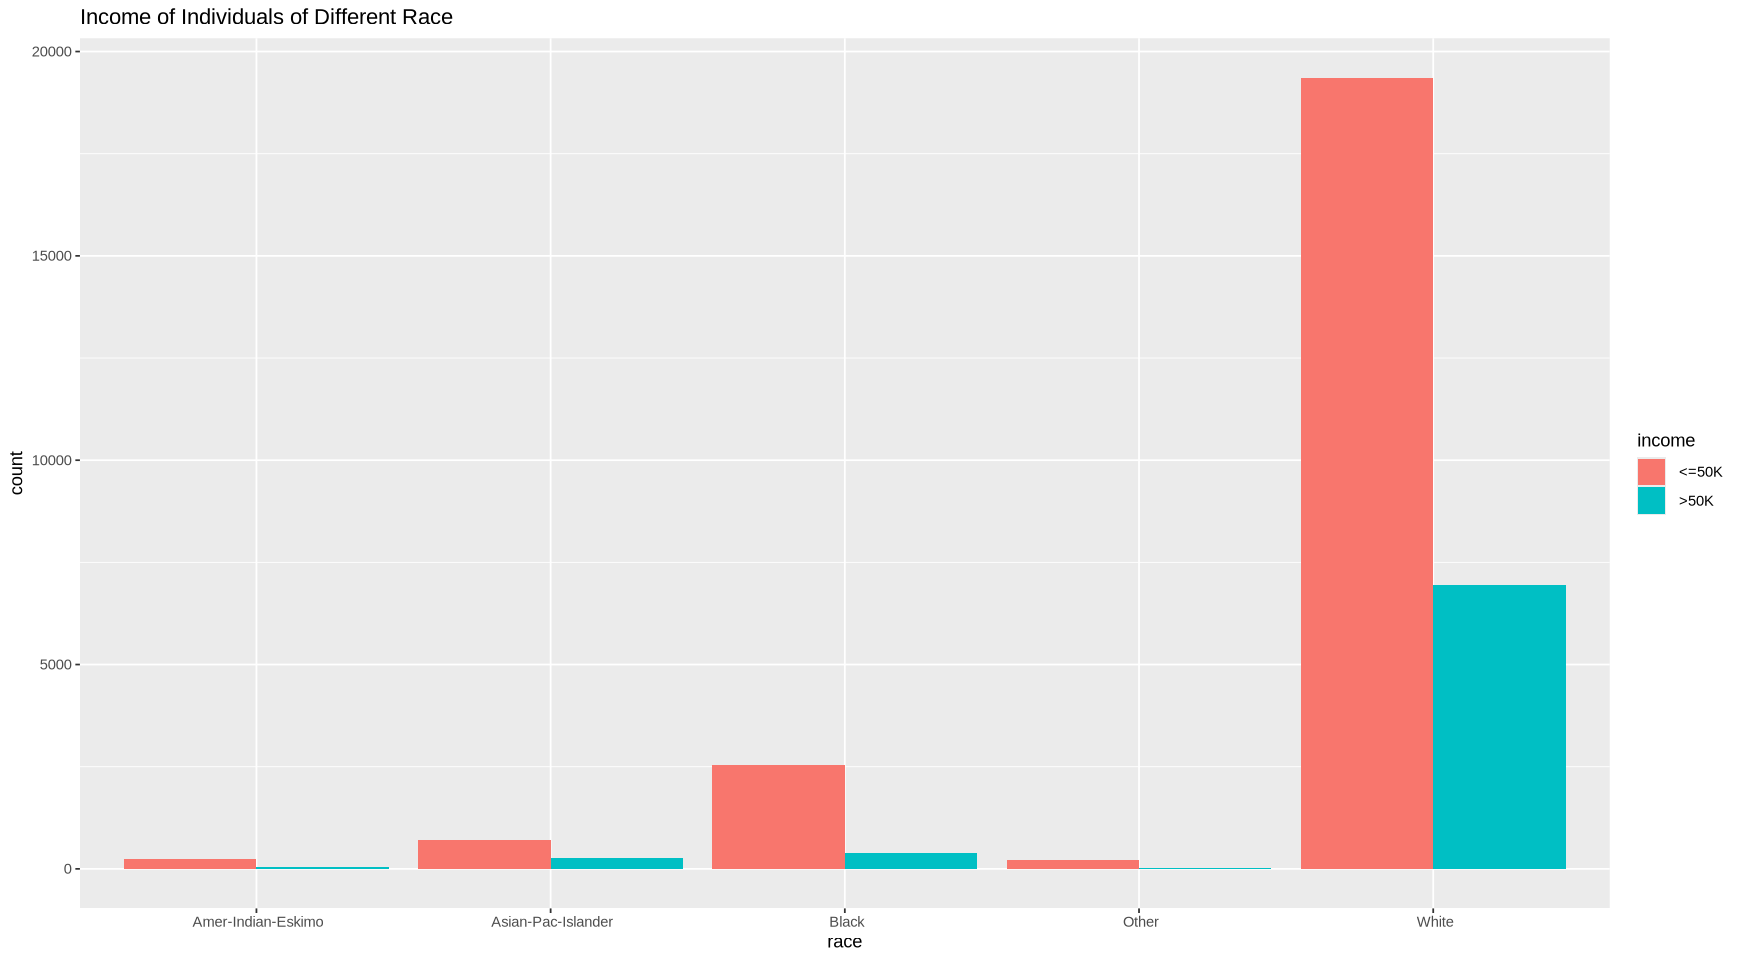

In [16]:
ggplot(adult_train,aes(race,fill=income))+
geom_bar(position='dodge')+ 
ggtitle("Income of Individuals of Different Race")

We see that the majority of the sample is white, and close to 25% of this category earn more than 50K $ per year.

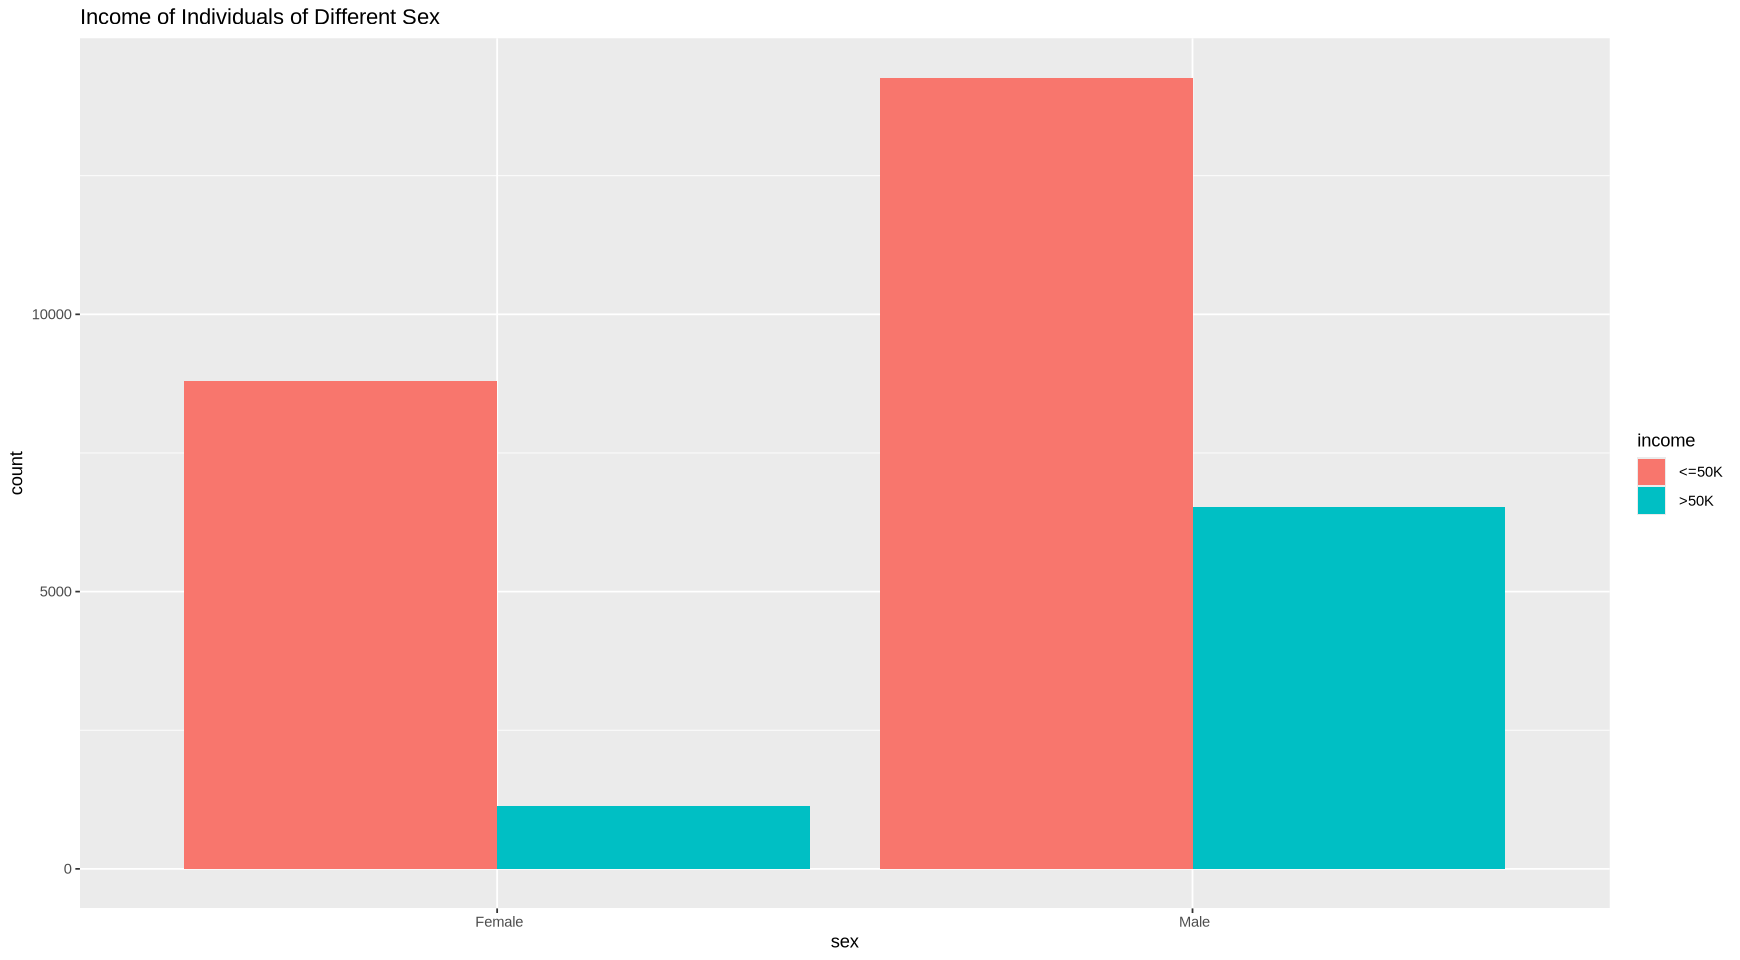

In [17]:
ggplot(adult_train,aes(sex,fill=income))+
geom_bar(position='dodge')+ 
ggtitle("Income of Individuals of Different Sex")

We see that there is a greater percentage of Males that earn more than 50K dollars per year than that of females

## Methods and Plan

We will expand the question a little bit by also trying to get a reasonably good predictive model.
For the question, the best model we can use to answer it is a logistic regression model, because it models the conditinal probability given a set of covariates. This model will also allow us to make inference and know if there is a relation between sex, education level, occupation and wheter or not that individual earns more than 50K a year, and also make predictions.

The assumptions needed in order to use a logistic regression are:

- **Binary Response**. The response variable is dichotomous (two possible responses) or the sum of dichotomous responses.
- **Independence**. The observations must be independent of one another.
- **Variance Structure**. By definition, the variance of a binomial random variable is $np(1-p) $.
- **Linearity**. The log of the odds ratio, $ \log( \frac{p}{1−p}) $, must be a linear function of  the covariates.

In order to select the variables for the logistic regression model, we will use LASSO and then fit a logistic regression with those variables. I will also use the education numerical variable insted of the categorical one to aim for a more simple model, with the tradeoff of a worse fitting, because if we used the numerical one in the logistic regression the coefficients for the different education levels would be a multiple of the coefficient that multiplies the `education_num` variable , and therefore they would constrained. In exchange, the resulting model will have more coefficients. 


## Implementation of a proposed model

Let us check for multicollinearity with the full (additive) logistic model

In [18]:
base_log_model=glm(formula=income~.,
       data=adult_train %>% select(-education_num),
       family="binomial")
vif(base_log_model)

,GVIF,Df,GVIF^(1/(2*Df))
age,1.239695,1,1.113416
workclass,1.556931,6,1.037582
fnlwgt,1.033013,1,1.016372
education,1.867682,15,1.021042
marital_status,54.494723,6,1.395392
occupation,2.701546,13,1.038964
relationship,115.913150,5,1.608471
race,1.085332,4,1.010288
sex,2.747291,1,1.657495
hours_per_week,1.130690,1,1.063339


In this case, as we have categorical variables with many factors, we get GVIF instead of VIF. GVIF was introduced by Monette and Fox in the paper "Generalized collinearity diagnostics," JASA 87:178-183, 1992 [link here](https://www.tandfonline.com/doi/abs/10.1080/01621459.1992.10475190).
We see that, as a rule of thumb, a value of $\text{GVIF}^{\frac{1}{2 \cdot Df}}$ higher than $\sqrt{5} = 2.23$ is of concern. As we see, all values are below this threshold, so we do not modify the variables.

Let us compute the matrix model to use the  LASSO aproach to select variables 

In [33]:
X_train=model.matrix(object=income~age+workclass+occupation+relationship+fnlwgt+education_num+marital_status+race+sex+hours_per_week,data=adult_train)[,-1]
X_test=model.matrix(object=income~age+workclass+occupation+relationship+fnlwgt+education_num+marital_status+race+sex+hours_per_week,data=adult_test)[,-1]
head(X_train)


,age,workclass Local-gov,workclass Never-worked,workclass Private,workclass Self-emp-inc,workclass Self-emp-not-inc,workclass State-gov,workclass Without-pay,occupation Armed-Forces,occupation Craft-repair,⋯,marital_status Married-spouse-absent,marital_status Never-married,marital_status Separated,marital_status Widowed,race Asian-Pac-Islander,race Black,race Other,race White,sex Male,hours_per_week
1,39,0,0,0,0,0,1,0,0,0,⋯,0,1,0,0,0,0,0,1,1,40
2,50,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,13
3,38,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,40
4,53,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,1,40
5,28,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0,40
6,37,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,40


In [34]:
lasso_model <-
     cv.glmnet(x=X_train , 
               y=adult_train %>% select(income) %>% as.matrix() , 
               alpha = 1,
              family="binomial",
              type.measure = "class",
              nfolds = 10)
lasso_model


Call:  cv.glmnet(x = X_train, y = adult_train %>% select(income) %>%      as.matrix(), type.measure = "class", nfolds = 10, alpha = 1,      family = "binomial") 

Measure: Misclassification Error 

      Lambda Index Measure       SE Nonzero
min 0.000602    63  0.1689 0.002337      35
1se 0.003524    44  0.1708 0.002003      29

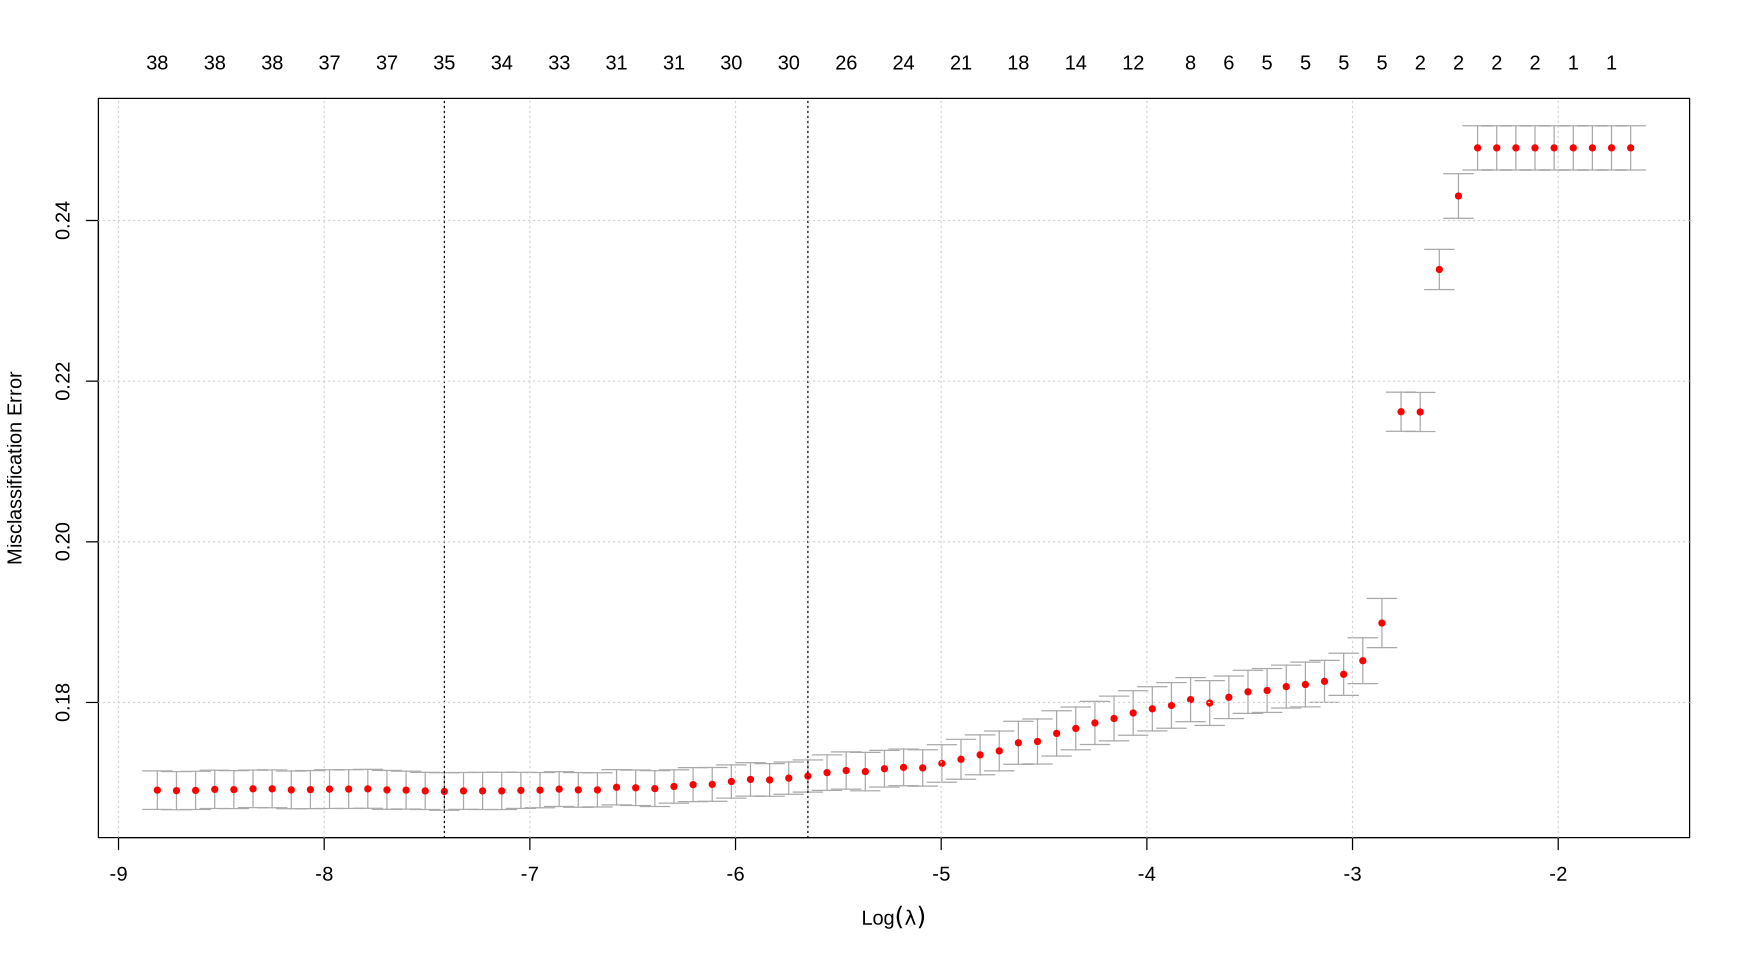

In [35]:
plot(lasso_model)
grid()

We select  $\lambda=\exp(-3)$ because it gives a more or less acceptable misclassification error, as seen in the plot

In [57]:
beta_lasso <- coef(lasso_model, s = exp(-3))
beta_lasso

41 x 1 sparse Matrix of class "dgCMatrix"
                                               s1
(Intercept)                          -4.411314312
age                                   0.004865345
workclass Local-gov                   .          
workclass Never-worked                .          
workclass Private                     .          
workclass Self-emp-inc                .          
workclass Self-emp-not-inc            .          
workclass State-gov                   .          
workclass Without-pay                 .          
occupation Armed-Forces               .          
occupation Craft-repair               .          
occupation Exec-managerial            0.137308069
occupation Farming-fishing            .          
occupation Handlers-cleaners          .          
occupation Machine-op-inspct          .          
occupation Other-service              .          
occupation Priv-house-serv            .          
occupation Prof-specialty             .          
occupati

In [22]:
lambda_min=lasso_model$lambda.min
lambda_min
beta_lasso_min=coef(lasso_model, s=lambda_min)
lambda_1se=lasso_model$lambda.1se
lambda_1se
beta_lasso_1se=coef(lasso_model, s=lambda_1se)

[1] 0.0001237379

[1] 0.001389977

Let us fit a LASSO model with `lambda_min`, which is the value that on average gives the lowest misclassification error. 

In [23]:
lasso_min_binary_model <-
     glmnet(x=X_train , 
               y=adult_train %>% select(income) %>% as.matrix() , 
               alpha = 1,
              family="binomial",
              lambda=lambda_min)
coef(lasso_min_binary_model)

55 x 1 sparse Matrix of class "dgCMatrix"
                                                s0
(Intercept)                          -6.637535e+00
age                                   2.914830e-02
workclass Local-gov                  -5.942070e-01
workclass Never-worked                .           
workclass Private                    -4.142961e-01
workclass Self-emp-inc               -1.721420e-01
workclass Self-emp-not-inc           -8.775142e-01
workclass State-gov                  -7.897854e-01
workclass Without-pay                -4.263709e+00
occupation Armed-Forces              -7.628242e-01
occupation Craft-repair               4.667028e-02
occupation Exec-managerial            7.919631e-01
occupation Farming-fishing           -9.535371e-01
occupation Handlers-cleaners         -7.310308e-01
occupation Machine-op-inspct         -3.404324e-01
occupation Other-service             -9.323197e-01
occupation Priv-house-serv           -2.288113e+00
occupation Prof-specialty             5.

We only nullified four coefficient, let us try with the lambda value that is on average one standard error away from the lambda that maximizes the AUC

In [38]:
beta_lasso <- coef(lasso_model, s = exp(-3))
beta_lasso

41 x 1 sparse Matrix of class "dgCMatrix"
                                               s1
(Intercept)                          -4.411314312
age                                   0.004865345
workclass Local-gov                   .          
workclass Never-worked                .          
workclass Private                     .          
workclass Self-emp-inc                .          
workclass Self-emp-not-inc            .          
workclass State-gov                   .          
workclass Without-pay                 .          
occupation Armed-Forces               .          
occupation Craft-repair               .          
occupation Exec-managerial            0.137308069
occupation Farming-fishing            .          
occupation Handlers-cleaners          .          
occupation Machine-op-inspct          .          
occupation Other-service              .          
occupation Priv-house-serv            .          
occupation Prof-specialty             .          
occupati

Let us join the levels of the factors that were nullified in the lasso model.

In [51]:
adult_train_joined=adult_train %>% mutate( 
                       marital_status = fct_collapse(marital_status,Not_Married_civ_spouse=c(" Divorced"," Married-AF-spouse"," Married-spouse-absent"," Married-spouse-absent"," Never-married" ," Separated"," Widowed")),
                       occupation=fct_collapse(occupation, Not_Exec_managerial=c(" Adm-clerical"," Armed-Forces"," Craft-repair"," Farming-fishing"," Handlers-cleaners"," Machine-op-inspct"," Other-service"," Priv-house-serv"," Prof-specialty"," Protective-serv"," Sales"," Tech-support"," Transport-moving")))
adult_test_joined=adult_test %>%   mutate(marital_status = fct_collapse(marital_status,Not_Married_civ_spouse=c(" Divorced"," Married-AF-spouse"," Married-spouse-absent"," Married-spouse-absent"," Never-married" ," Separated"," Widowed")),
                       occupation=fct_collapse(occupation, Not_Exec_managerial=c(" Adm-clerical"," Armed-Forces"," Craft-repair"," Farming-fishing"," Handlers-cleaners"," Machine-op-inspct"," Other-service"," Priv-house-serv"," Prof-specialty"," Protective-serv"," Sales"," Tech-support"," Transport-moving")))
head(adult_train_joined)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,income
,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>
1,39,State-gov,77516,Bachelors,13,Not_Married_civ_spouse,Not_Exec_managerial,Not-in-family,White,Male,40,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,<=50K
3,38,Private,215646,HS-grad,9,Not_Married_civ_spouse,Not_Exec_managerial,Not-in-family,White,Male,40,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Not_Exec_managerial,Husband,Black,Male,40,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Not_Exec_managerial,Wife,Black,Female,40,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,<=50K


Now let us fit the model with the variables lasso has selected

In [49]:
binary_log_model <- 
   glm(formula=income~age+occupation+education_num+marital_status+hours_per_week,
       data=adult_train_joined,
       family="binomial")
summary(binary_log_model)


Call:
glm(formula = income ~ age + occupation + education_num + marital_status + 
    hours_per_week, family = "binomial", data = adult_train_joined)

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -9.121215   0.130783  -69.74   <2e-16 ***
age                                0.032190   0.001408   22.86   <2e-16 ***
occupation Exec-managerial         0.705774   0.043470   16.24   <2e-16 ***
education_num                      0.363471   0.007494   48.50   <2e-16 ***
marital_status Married-civ-spouse  2.319900   0.039089   59.35   <2e-16 ***
hours_per_week                     0.030010   0.001465   20.49   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 34483  on 30717  degrees of freedom
Residual deviance: 23104  on 30712  degrees of freedom
AIC: 23116

Number of Fisher Scoring iterations: 6


We see that age, education and occupation are statistically significant, based on the p-values obtained, answering the first part of our question.

Now we compute the confusion matrix to discover the goodnes of fit of the prediction model in the test set

In [52]:
 confusion_matrix1 <- 
     confusionMatrix(data = as.factor(if_else(predict(binary_log_model,adult_test_joined, type="response")>0.5, " >50K.", " <=50K.")),
     reference = adult_test_joined$income,
     positive = " >50K.")
confusion_matrix1
paste("AUC:",round(auc(response = adult_test_joined$income,
   predictor = predict(binary_log_model,adult_test_joined, type="response")),3))

Confusion Matrix and Statistics

          Reference
Prediction  <=50K.  >50K.
    <=50K.   10613   1823
    >50K.      930   1949
                                          
               Accuracy : 0.8202          
                 95% CI : (0.8141, 0.8263)
    No Information Rate : 0.7537          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4739          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5167          
            Specificity : 0.9194          
         Pos Pred Value : 0.6770          
         Neg Pred Value : 0.8534          
             Prevalence : 0.2463          
         Detection Rate : 0.1273          
   Detection Prevalence : 0.1880          
      Balanced Accuracy : 0.7181          
                                          
       'Positive' Class :  >50K.          
         

Setting levels: control =  <=50K., case =  >50K.

Setting direction: controls < cases



[1] "AUC: 0.873"

We then see that the sensitivity is lower than the specificity, this may be due unequal proportion of people earning more or less than 50K per year. We could change this values if we wanted by changing the threshold used to predict the classes (in this case we used 0.5), if we used a lower value, we would get more sensitivity and less specificity, for example. We could also try to improve accuracy by trying to add interaction between the variables in the model.

In [28]:
few_var_binary_regression=glm(income~age+marital_status+education_num,data=adult_train,family="binomial")

In [29]:
summary(few_var_binary_regression)


Call:
glm(formula = income ~ age + marital_status + education_num, 
    family = "binomial", data = adult_train)

Coefficients:
                                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -7.627815   0.121534 -62.763  < 2e-16 ***
age                                   0.028261   0.001443  19.585  < 2e-16 ***
marital_status Married-AF-spouse      2.678570   0.462620   5.790 7.04e-09 ***
marital_status Married-civ-spouse     2.110595   0.055875  37.773  < 2e-16 ***
marital_status Married-spouse-absent -0.165705   0.200604  -0.826   0.4088    
marital_status Never-married         -0.558553   0.073142  -7.637 2.23e-14 ***
marital_status Separated             -0.207046   0.142840  -1.449   0.1472    
marital_status Widowed               -0.259508   0.135458  -1.916   0.0554 .  
education_num                         0.393964   0.007419  53.104  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion p

In [30]:
confusion_matrix2 <- 
     confusionMatrix(data = as.factor(if_else(predict(few_var_binary_regression,adult_test, type="response")>0.5, " >50K.", " <=50K.")),
     reference = adult_test$income,
     positive = " >50K.")
confusion_matrix2

Confusion Matrix and Statistics

          Reference
Prediction  <=50K.  >50K.
    <=50K.   10643   1947
    >50K.      900   1825
                                          
               Accuracy : 0.8141          
                 95% CI : (0.8079, 0.8202)
    No Information Rate : 0.7537          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4477          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4838          
            Specificity : 0.9220          
         Pos Pred Value : 0.6697          
         Neg Pred Value : 0.8454          
             Prevalence : 0.2463          
         Detection Rate : 0.1192          
   Detection Prevalence : 0.1779          
      Balanced Accuracy : 0.7029          
                                          
       'Positive' Class :  >50K.          
         

In [31]:
y=if_else(adult_train$income==" <=50K",0,1)
Xy=data.frame(cbind(X_train,y))
table(y)

y
    0     1 
23068  7650 

In [32]:
forward_sel=regsubsets(income~.,data=adult_train, nvmax=4, method="exhaustive")
summary(forward_sel)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2  linear dependencies found”


Reordering variables and trying again:


ERROR: Error in leaps.exhaustive(a, really.big): Exhaustive search will be S L O W, must specify really.big=T


In [ ]:
few_var2_binary_regression=glm(income~age+occupation+education_num+marital_status,data=adult_train, family="binomial")
summary(few_var2_binary_regression)

In [ ]:
confusion_matrix3 <- 
     confusionMatrix(data = as.factor(if_else(predict(few_var2_binary_regression,adult_test, type="response")>0.5, " >50K.", " <=50K.")),
     reference = adult_test$income,
     positive = " >50K.")
confusion_matrix3